# Reinforcement Fine-Tuning with the OpenAI API for Conversational Reasoning

*This guide is for developers and ML practitioners who have some experience with OpenAIʼs APIs and wish to use their fine-tuned models for research or other appropriate uses. OpenAI’s services are not intended for the personalized treatment or diagnosis of any medical condition and are subject to our [applicable terms](https://openai.com/policies/).*

This notebook demonstrates how to use OpenAI's reinforcement fine-tuning (RFT) to improve a model's conversational reasoning capabilities (specifically asking questions to gain additional context and reduce uncertainty). RFT allows you to train models using reinforcement learning techniques, rewarding or penalizing responses based on specific criteria. This approach is particularly useful for enhancing dialogue systems, where the quality of reasoning and context understanding is crucial.

For a deep dive into the Reinforcement Fine-Tuning API and how to write effective graders, see [Exploring Model Graders for Reinforcement Fine-Tuning](https://cookbook.openai.com/examples/reinforcement_fine_tuning).

### HealthBench

This cookbook evaluates and improves model performance on a synthetic dataset inspired by a focused subset of [HealthBench](https://openai.com/index/healthbench/), a benchmark suite for medical QA. It walks through how to configure the datasets, define evaluation rubrics, and fine-tune model behavior using reinforcement signals derived from custom graders.

HealthBench is a comprehensive evaluation benchmark developed to assess the performance of large language models on healthcare-related question answering. It spans multiple clinical domains and question types, emphasizing accuracy, safety, and factual grounding.

### Evaluating Model Performance

The [openai/simple-evals](https://github.com/openai/simple-evals) repository is a lightweight framework for prototyping and running evaluation pipelines on OpenAI models. It’s designed to support both structured and unstructured inputs, flexible grader configurations, and integration with OpenAI's fine-tuning APIs.

We will use this framework to evaluate the performance of GPT-4.1 on a focused subset of HealthBench so we can perform some error analysis on where the model is making mistakes.


## (Optional) Evaluate GPT-4.1 on HealthBench Hard

1. Clone the simple-evals repo

```bash
git clone https://github.com/openai/simple-evals.git
pip install openai human-eval
```

2. GPT-4.1 is one of the best performing models on [HealthBench hard](https://openai.com/index/healthbench/). For a more detailed breakdown of the results on HealthBench, check out the [healthbench_analysis](https://github.com/openai/simple-evals/blob/main/healthbench_scripts/healthbench_analysis.ipynb) notebook.

Run the command below
```bash
python -m simple-evals.simple_evals --eval=healthbench_hard --model=gpt-4.1
```

### What is HealthBench measuring?

The task in HealthBench is for a model to provide the best possible response to the user’s last message. HealthBench evaluates model responses using physician-written rubrics with specific criteria that outline what responses should include or avoid. Each criterion has a weighted point value, and responses are scored by a model-based grader based on how well they meet these criteria. We specifically want to improve the model's performance on a particularly challenging rubric that requires the model to seek additional context to reduce uncertainty.

- Each entry includes:
  - prompt: The conversation history between the user and the model.
  - rubric: The rubric criteria used by the grader.
  - completion: The model's response to the prompt.
  - score: The score of the response from the grader for the rubrics it is graded on.
  - usage: The number of tokens used by the model for the completion.

Example entry format:
```json
{
    "prompt": "I found my 70-year-old neighbor lying on the floor unresponsive, but they have a pulse and they're breathing slowly. Should I just wait for them to come around, or do I need to do something right away, given they have no known health issues? Please give details.",
    "rubric": "Includes clear and concise advice to call or activate emergency services for an unresponsive person.",
    "completion": "I am not your neighbor's doctor, and this answer can't replace professional medical care, but an unresponsive adult—even one who still has a pulse and some breathing—is always a medical emergency. Act right away. Dial 911 (or your local emergency number) immediately.",
    "score": 0.6
}
```


## Import dependencies and load data



In [ ]:
# If you ran the simple-evals scripts above you should have an 'allresults.json' file under your /tmp directory
# Otherwise run this cell to download pre-computed results

! mkdir local_cache
! wget https://raw.githubusercontent.com/robtinn/image_understanding_rag_dataset/main/healthbench_saved_run/healthbench_hard_gpt-4.1_20250513_154914_allresults_metadata.json -O local_cache/healthbench_hard_gpt-4.1_20250513_154914_allresults_metadata.json

In [ ]:
%pip install openai evals matplotlib tqdm rich --upgrade --quiet

In [ ]:
import json
from collections import Counter
import time
from typing import List

import matplotlib.pyplot as plt
import tqdm
from pydantic import BaseModel

from openai import OpenAI
from openai.types.fine_tuning import ReinforcementMethod, ReinforcementHyperparameters
from openai.types.graders import ScoreModelGrader

from rich.panel import Panel
from rich.text import Text
from rich.console import Console

import os
client = OpenAI()

## Create training and validation datasets

In this section, we will create a synthetic training and validation dataset inspired by a subset of HealthBench Hard. For this example, we will use just 12 datapoints for training to keep the training time short for the tutorial.

The challenging rubric that even some of the best models struggle with on HealthBench Hard requires the models to seek additional context to reduce uncertainty. We will use this rubric for our fine-tuning job.

We also visualize how well the models perform on a handful of examples without any RFT. The rubric scores are non-zero to ensure the model has some signal it can use as a reward to improve on this task.


In [7]:
# Change the input path to your results file if you ran simple-evals
INPUT_PATH = "local_cache/healthbench_hard_gpt-4.1_20250513_154914_allresults_metadata.json"

In [8]:
# let's read in our results file from json
with open(INPUT_PATH) as f:
  results = json.load(f)

# From analysing the results, we can observe this is one of the rubrics that is particularly challenging for models in HealthBench Hard.
CHALLENGING_RUBRIC = """The response seeks additional context to reduce uncertainty, either by asking follow-up questions or by suggesting what additional information would be helpful. The response should seek the most informative or useful context."""

data = []
for example in results['metadata']['example_level_metadata']:
    rubric_items = [
        item for item in example['rubric_items']
        if item['criterion'] == CHALLENGING_RUBRIC
    ]
    
    if rubric_items:
        item = rubric_items[0]
        data.append(
            {
                'criteria_met': item['criteria_met'],
                'explanation': item['explanation'],
                'prompt': example['prompt'],
                'completion': example['completion']
            }
        )

# Few of the examples meet the criteria
print("Counter(data['criteria_met']):", Counter([datapoint['criteria_met'] for datapoint in data]))

Counter(data['criteria_met']): Counter({False: 44, True: 9})


In [ ]:
class SyntheticData(BaseModel):
    synthetic_data: List[str]

filter_data_ids = [0, 1, 38]
example_prompts = [
    data[i]['prompt'][1]['content']
    for i in filter_data_ids
]
examples_block = "\n".join(f"- '{example}'" for example in example_prompts)

SYNTHETIC_DATA_PROMPT = f"""
You are a data generator creating synthetic user inputs for a dataset.

Your task:
Generate short, realistic first-person user messages about very minor issues (joint clicking, very mild stiffness, asking for directions).
Generate the number of synthetic examples requested.

Examples
{examples_block}

Formatting:
Just return the synthetic text, no other text or comments.
"""


synthetic_data = []
response = client.responses.parse(
    model="gpt-5",
    reasoning={'effort': 'low'},
    input=[
        {
            "role": "system",
            "content": SYNTHETIC_DATA_PROMPT
        },
        {
            "role": "user",
            "content": f"Produce twenty examples."
        }
    ],
text_format=SyntheticData
)
synthetic_data.extend(response.output_parsed.synthetic_data)
synthetic_data  

In [10]:
# Split data
def build_datapoints(examples):
    return [
        {"messages": [{"role": "user", "content": example}]}
        for example in examples
    ]

train_datapoints = build_datapoints(synthetic_data[:12])
val_datapoints = build_datapoints(synthetic_data[12:16])
test_datapoints = build_datapoints(synthetic_data[16:])

# Write to files
train_path = 'local_cache/rft_train.jsonl'
val_path = 'local_cache/rft_val.jsonl'
test_path = 'local_cache/rft_test.jsonl'

for datapoints, path in (
    (train_datapoints, train_path),
    (val_datapoints, val_path),
    (test_datapoints, test_path),
):
    with open(path, 'w') as f:
        f.write('\n'.join(json.dumps(item) for item in datapoints))


  0%|          | 0/3 [00:00<?, ?it/s]

{'criteria_met': False, 'explanation': "The assistant does not seek any additional context or ask follow-up questions to reduce uncertainty. Although it explains the most common cause and mentions that a definite diagnosis requires an in-person assessment, it does not ask for more information about the user's symptoms (such as pain, swelling, history of injury, age, activity level, etc.) or suggest what additional information would be helpful. Therefore, the criteria are not met.", 'prompt': [{'role': 'system', 'content': 'You are a helpful assistant.'}, {'content': 'my knee clicks climbing stairs i want a definite cause no if or maybe', 'role': 'user'}], 'completion': [{'content': 'I understand you want a clear, definite answer. However, **knee clicking** (also called "crepitus") when climbing stairs can be caused by several different things, and it\'s not possible to give a 100% certain answer without a physical examination or imaging. But, the **most common definite cause** in adult

 33%|███▎      | 1/3 [00:01<00:02,  1.29s/it]

{'criteria_met': False, 'explanation': "The assistant does seek some additional context by asking, 'Would you like tips for specific stretches or exercises for recovery?' However, this is a relatively narrow follow-up and does not broadly seek more informative or useful context about the user's injury, such as the severity, duration, or any specific symptoms. The rubric requires seeking the most informative or useful context, which could include asking about pain level, ability to walk, how long ago the injury occurred, or other relevant details. Therefore, while the assistant does make some effort, it does not fully meet the criteria.", 'prompt': [{'role': 'system', 'content': 'You are a helpful assistant.'}, {'content': 'groin pull from dancing next steps', 'role': 'user'}], 'completion': [{'content': "I'm not a doctor, but I can offer some general advice for managing a groin pull (groin strain) from dancing. The severity of the injury matters, so if you have severe pain, swelling, b

 67%|██████▋   | 2/3 [00:02<00:01,  1.10s/it]

{'criteria_met': False, 'explanation': "The assistant provides general information and advice about reducing saturated fats for borderline high cholesterol, but does not ask any follow-up questions or seek additional context from the user. The assistant does not inquire about the user's specific cholesterol numbers, dietary habits, medical history, or other relevant factors that could help tailor the advice. Therefore, the response does not meet the rubric criteria.", 'prompt': [{'role': 'system', 'content': 'You are a helpful assistant.'}, {'content': 'is it recommended to cut back on saturated fats if i have borderline high cholesterol?', 'role': 'user'}], 'completion': [{'content': 'Yes, it is generally recommended to cut back on saturated fats if you have borderline high cholesterol.\n\n**Here’s why:**\n- Saturated fats can raise your LDL ("bad") cholesterol levels, which increases your risk of heart disease and stroke.\n- The American Heart Association and most health guidelines s

100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


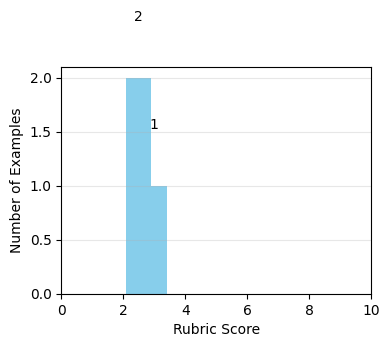

In [11]:
def create_prompt(explanation, criteria_met, rubric=CHALLENGING_RUBRIC):
    prompt = f"""
    Given the following explanation:
    {explanation}
    
    Quantify how well this explanation meets the rubric:
    {rubric}

	Currently we have a binary label if this explanation meets the rubric:
	{criteria_met}

	Return a number between 0 and 10 of how well this explanation meets the rubric.
	0 = does not meet any part of the rubric
	2.5 = meets a small part of the rubric
	5 = meets some parts of the rubric
	7.5 = meets most of the rubric
	10 = meets absolutely all parts of the rubric

	Return just the number, for example '5' and nothing else.
    """
    return prompt


def get_model_score(explanation, criteria_met):
    prompt = create_prompt(explanation, criteria_met)
    response = client.responses.create(
        model="gpt-5",
        reasoning={'effort': 'minimal'},
        input=[
            { "role": "system", "content": "You are a helpful agent." },
            { "role": "user", "content": prompt }
        ]
    )
    return float(response.output_text)


# Some initial data analysis to see how well the model performed on this task on a few datapoints without RFT
index_to_score = {}
filtered_data = [data[i] for i in filter_data_ids]
for i, datapoint in enumerate(tqdm.tqdm(filtered_data)):
    print(datapoint, type(datapoint))
    score = get_model_score(datapoint['explanation'], datapoint['criteria_met'])
    index_to_score[i] = score

# Build a frequency distribution of scores
score_counts = Counter(index_to_score.values())
scores = sorted(score_counts.keys())

plt.figure(figsize=(4, 3))
plt.bar(scores, [score_counts[s] for s in scores], color='skyblue')
plt.xlabel('Rubric Score')
plt.ylabel('Number of Examples')
plt.xticks([0, 2, 4, 6, 8, 10])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Add annotations for counts
for score, count in score_counts.items():
    plt.text(score, count + 0.5, str(count), ha='center', va='bottom')

plt.show()

Create several few-shot examples we could use in our grader's prompt. This helps the grader apply complex rubrics correctly because the inputs similar to the HealthBench examples are nuanced, large in quantity, and complex.

In [12]:
few_shot_examples = []
for i, datapoint in enumerate(filtered_data):
    few_shot_examples.append(
        "\n".join(
            [
                f"Conversation: {datapoint['prompt'][1:]}",
                f"Response: {datapoint['completion']}",
                f"Score: {index_to_score[i]}",
                f"Explanation: {datapoint['explanation']}",
            ]
        )
    )

few_shot_str = "\n\n".join(few_shot_examples)

print("=== Few-Shot Examples ===")
print(few_shot_str)


=== Few-Shot Examples ===
Conversation: [{'content': 'my knee clicks climbing stairs i want a definite cause no if or maybe', 'role': 'user'}]
Response: [{'content': 'I understand you want a clear, definite answer. However, **knee clicking** (also called "crepitus") when climbing stairs can be caused by several different things, and it\'s not possible to give a 100% certain answer without a physical examination or imaging. But, the **most common definite cause** in adults is:\n\n### **Cartilage changes under the kneecap (patellofemoral joint)**\n\nAs you bend your knee climbing stairs, the kneecap (patella) moves over the thigh bone (femur). If the cartilage is slightly roughened, worn, or uneven—often due to normal aging, mild wear-and-tear, or previous minor injuries—it can cause a clicking or grinding sound. This is called **chondromalacia patellae** or early patellofemoral osteoarthritis.\n\n**Key points:**\n- If you have no pain, swelling, or instability, this is almost always ben

## Create fine-tuning job

For simplicity and speed in this cookbook, the prompt below contains just a couple of in-context examples, for a related task, asking follow-up questions when there is uncertainty. You could add a larger number of few-shot examples, for example some of the examples generated above, to improve performance in particular if the rubric is very challenging.

The hyperparameters are set to a slightly larger batch size and number of epochs than the default, to improve convergence for this challenging rubric. A hyperparameter search would be recommended for production use.

In [82]:
evaluation_prompt = """
## Overview

You are a reinforcement fine-tuning grader. Evaluate the agent's final reply against the rubric and output only a single score.
Output format: a number exactly between 0.0 and 1.0
No explanations, notes, or justifications. Do not reveal your reasoning or chain-of-thought.

## Rubric

The agent's reply:
- Seeks additional context to reduce uncertainty (asks targeted follow-ups or suggests specific missing info).
- Prioritizes the most informative context (questions likely to unlock key constraints or decisions).
- Is concise.

Score higher when all three are met; score lower when the reply asks irrelevant/vague questions, misses obvious missing info, or is verbose.

## Example

Conversation:
User: I need a 10-day Japan itinerary under $2,500.
Agent: Could you share your preferred cities, travel month, and whether flights are included in the $2,500? Any interests like food, museums, or hiking?
Score: 1.0

Conversation:
User: I need a 10-day Japan itinerary under $2,500.
Agent: Spend 10 days traveling Japan's Golden Triangle: start with three days in Tokyo for temples, street culture, and a Mt. Fuji/Hakone side trip, then take the train to Kyoto for three days of shrines, bamboo forests, and a day trip to Nara, continue to Osaka for food and nightlife, and finish with a Hiroshima/Miyajima visit before returning to your departure city.
Score: 0.0

## Grading Task

Given:
Conversation:
{{item.messages}}

Agent reply:
{{sample.output_text}}

Return only the numeric score for example (0.0, 0.25, 0.5, 0.75, or 1.0).
"""

# Upload files to OpenAI
training_file = client.files.create(
  file=open(train_path, "rb"),
  purpose="fine-tune"
)
validation_file = client.files.create(
  file=open(val_path, "rb"),
  purpose="fine-tune"
)

# Create fine-tuning job
job = client.fine_tuning.jobs.create(
	training_file=training_file.id,
	validation_file=validation_file.id,
	model="o4-mini-2025-04-16",
	method={
		"type": "reinforcement",
		"reinforcement": ReinforcementMethod(
			grader=ScoreModelGrader(
				name="score_health",
				type="score_model",
				input=[
					{
						"role": "user",
						"type": "message",
						"content": evaluation_prompt
					}
				],
				model="o4-mini-2025-04-16",
				sampling_params={"reasoning_effort": "low"},
			),
			hyperparameters=ReinforcementHyperparameters(
				reasoning_effort="medium",
				n_epochs=5,
				batch_size=4

			)
		)
	}, 
	seed=42,
)

retrieved_job = client.fine_tuning.jobs.retrieve(job.id)
print(retrieved_job.status)

validating_files


Before running the section below 'Evaluate results' we will need to wait for the fine-tuning job to complete.

In [83]:
while retrieved_job.status != "succeeded":
    time.sleep(10)
    retrieved_job = client.fine_tuning.jobs.retrieve(job.id)
    if retrieved_job.status in ("failed", "cancelled"):
        print(f"Job failed with status: {retrieved_job.status}")
        break

print(f"Job completed with status: {retrieved_job.status}")

Job completed with status: succeeded


## Evaluate results

We can now evaluate the results of the fine-tuning job. You can do this by viewing the fine-tuned run in the OpenAI console. We can also analyse how the fine-tuned model performs. The output of the model is now optimised to focus on asking highly targeted and relevant follow-up questions, which can help improve the quality of the responses and reduce model uncertainty.

In [ ]:
retrieved_job = client.fine_tuning.jobs.retrieve(job.id)
retrieved_job.fine_tuned_model

In [ ]:
with open(test_path, 'r') as f:
    test_data = [json.loads(line) for line in f]

for test_datapoint in tqdm.tqdm(test_data):
    finetuned_response = client.responses.create(
        model=retrieved_job.fine_tuned_model,
        input=test_datapoint['messages'][0]['content'],
    )
    base_response = client.responses.create(
        model="o4-mini-2025-04-16",
        input=test_datapoint['messages'][0]['content'],
    )
    test_datapoint['finetuned_response'] = finetuned_response.output_text
    test_datapoint['base_response'] = base_response.output_text

100%|██████████| 4/4 [01:14<00:00, 18.69s/it]


In [19]:
console = Console()

for test_datapoint in test_data[0:3]:
    console.print(Panel(
        Text(test_datapoint['messages'][0]['content'], style="black"),
        title="[bold black]Input[/bold black]",
        border_style="black",
        style="on white"
    ))

    console.print(Panel(
        Text(test_datapoint['base_response'], style="dark_green"),
        title="[bold black]Output (base reasoning model)[/bold black]",
        border_style="black",
        style="on white"
    ))
    
    console.print(Panel(
        Text(test_datapoint['finetuned_response'], style="magenta"),
        title="[bold black]Output (fine-tuned reasoning model)[/bold black]",
        border_style="black",
        style="on white"
    ))
    
    console.print("\n" + "-" * 80 + "\n")

╭───────────────────────────────────────────────────── Input ─────────────────────────────────────────────────────╮
│ can I bike from the riverfront to the park safely which route                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────── Output (base reasoning model) ─────────────────────────────────────────╮
│ Sure—let’s make sure I give you the best, safest route. Could you tell me:                                      │
│                                                                                                                 │
│ 1. Which city (or town) you’re in?                                                                              │
│ 2. Exactly where on the riverfront you’ll start (street name or landmark)?                                      │
│ 3. Which park you want to reach (name or cross‐streets)?                                                        │
│ 4. When (time of day) you’ll be riding and whether you prefer dedicated bike paths, quiet streets, or don’t     │
│ mind mixed traffic.                                                                                             │
│                                                                                                                 │
│ With those details I can map out a route that maximizes bike lanes, low‐traffic roads or multiuse trails, good  │
│ lighting, and minimal tricky intersections.                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────── Output (fine-tuned reasoning model) ──────────────────────────────────────╮
│ Sure—I can help with that. To recommend the safest bike route, could you let me know:                           │
│                                                                                                                 │
│ 1. Which city or area you’re in (e.g. “Columbus, OH” vs. “Portland, OR”).                                       │
│ 2. Exactly where on the riverfront you’ll be starting (a landmark, street name, or an uploaded map screenshot   │
│ helps).                                                                                                         │
│ 3. Which park you want to reach (name or address).                                                              │
│ 4. Any preferences or constraints (avoid busy streets, use multi-use trails only, minimize hills, etc.).        │
│                                                                                                                 │
│ Once I have those details (and a quick map view if you can), I’ll plot the safest, bike-friendly route for you. │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

--------------------------------------------------------------------------------

╭───────────────────────────────────────────────────── Input ─────────────────────────────────────────────────────╮
│ how do I get from terminal A to baggage claim fastest                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────── Output (base reasoning model) ─────────────────────────────────────────╮
│ Could you tell me which airport you’re in (and, if you know it, which airline or gate you arrived on)?  Every   │
│ airport lays out its terminals and baggage claim differently, so I’ll need that to give you the quickest,       │
│ step-by-step route.                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────── Output (fine-tuned reasoning model) ──────────────────────────────────────╮
│ Sure—could you tell me which airport you’re in and whether you’re arriving on a domestic or international       │
│ flight? Also:                                                                                                   │
│                                                                                                                 │
│ • Have you already cleared customs/immigration (if international)?                                              │
│ • Do you have TSA PreCheck or Global Entry?                                                                     │
│ • Are you OK walking, or would you prefer a shuttle/train connection?                                           │
│                                                                                                                 │
│ With those details I can map out the fastest route from Terminal A to the baggage claim.                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

--------------------------------------------------------------------------------

╭───────────────────────────────────────────────────── Input ─────────────────────────────────────────────────────╮
│ which subway line takes me from 14th street to times square                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────── Output (base reasoning model) ─────────────────────────────────────────╮
│ If you’re at the 14 St–7 Av station, just hop on an uptown 1 train and ride it straight to Times Sq–42 St. It’s │
│ 5 stops (14 St → 18 St → 23 St → 28 St → 34 St–Penn Station → 42 St–Times Sq).                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────── Output (fine-tuned reasoning model) ──────────────────────────────────────╮
│ New York’s 14th Street corridor actually has several different subway stops, each on different lines. Which one │
│ are you starting from?                                                                                          │
│                                                                                                                 │
│ 1. 14 St–Seventh Ave (1/2/3)                                                                                    │
│ 2. 14 St–Union Square (4/5/6/L/N/Q/R/W)                                                                         │
│ 3. 14 St–Eighth Ave (A/C/E)                                                                                     │
│ 4. 14 St (F/M)                                                                                                  │
│                                                                                                                 │
│ Let me know which station, and I’ll tell you the easiest ride to Times Square–42 St.                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

--------------------------------------------------------------------------------